In [1]:
from inspect import isfunction

In [2]:
import json

In [3]:
import numpy as np

In [4]:
from pyiron_workflow import Workflow, to_function_node

In [5]:
from pyiron_workflow.nodes.standard import GetItem

In [6]:
from simple_workflow import (
    add_x_and_y as _add_x_and_y, 
    add_x_and_y_and_z as _add_x_and_y_and_z,
)

In [7]:
def get_linked_nodes(graph_dict):
    nodes_dict = {}
    node_mapping_dict = {}
    input_dict = {}
    for i, [k, v] in enumerate(wf.graph_as_dict["nodes"].items()):
        nodes_dict[i] = v.node_function
        node_mapping_dict[k] = i
        input_dict[k] = {
            con.full_label: con.value 
            for con in v.inputs.channel_dict.to_list() 
            if len(con.connections) == 0
        }
    return nodes_dict, node_mapping_dict, input_dict

In [8]:
def extend_nodes_dict(nodes_dict, input_dict):
    i = len(nodes_dict)
    nodes_links_dict = {}
    for val_dict in input_dict.values():
        for k, v in val_dict.items():
            if v not in nodes_dict.values():
                nodes_dict[i] = v
                nodes_links_dict[k] = i
                i += 1
            else:
                nodes_links_dict[k] = {tv:tk for tk, tv in nodes_dict.items()}[v]
    return nodes_links_dict

In [9]:
def get_edges(graph_dict, node_mapping_dict, nodes_links_dict):
    edges_lst = []
    for link in list(graph_dict["edges"]["data"].keys()):
        source_combo, target_combo = link
        target, target_handle = target_combo.split(".")
        source, source_handle = source_combo.split(".")
        edges_lst.append({'target': node_mapping_dict[target], 'targetHandle': target_handle, 'source': node_mapping_dict[source], 'sourceHandle': source_handle})

    for k, v in nodes_links_dict.items():
        target, target_handle = k.split(".")
        edges_lst.append({'target': node_mapping_dict[target], 'targetHandle': target_handle, 'source': v, 'sourceHandle': None})
    return edges_lst

In [10]:
add_x_and_y = to_function_node("add_x_and_y", _add_x_and_y, "add_x_and_y")
add_x_and_y_and_z = to_function_node("add_x_and_y_and_z", _add_x_and_y_and_z, "add_x_and_y_and_z")

In [11]:
wf = Workflow("my_workflow")

In [12]:
wf.x = 1
wf.y = 2
wf.data = add_x_and_y(x=wf.x, y=wf.y)
wf.w = add_x_and_y_and_z(x=wf.data["x"], y=wf.data["y"], z=wf.data["z"])

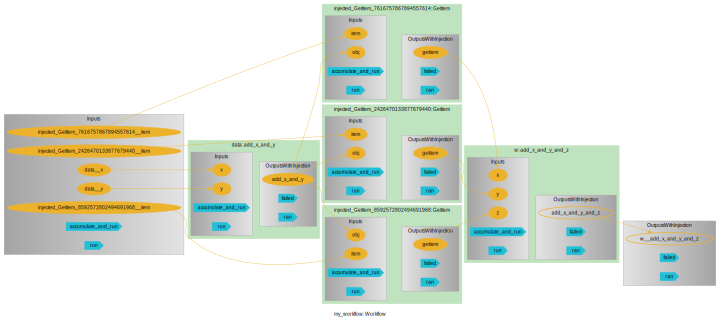

In [13]:
wf.draw(size=(10,10))

In [14]:
wf.run()

{'w__add_x_and_y_and_z': 6}

In [15]:
nodes_dict, node_mapping_dict, input_dict = get_linked_nodes(graph_dict=wf.graph_as_dict)
nodes_links_dict = extend_nodes_dict(nodes_dict=nodes_dict, input_dict=input_dict)
edges_lst = get_edges(
    graph_dict=wf.graph_as_dict, 
    node_mapping_dict=node_mapping_dict, 
    nodes_links_dict=nodes_links_dict,
)

In [16]:
pyiron_workflow_modules = {}
for k, v in nodes_dict.items():
    if isfunction(v) and "pyiron_workflow" in v.__module__:
        pyiron_workflow_modules[k] = v

In [17]:
target_dict = {}
for edge in edges_lst:
    for k in pyiron_workflow_modules.keys():
        if k == edge['target']:
            if k not in target_dict:
                target_dict[k] = []
            target_dict[k].append(edge)

In [18]:
source_dict = {}
for edge in edges_lst:
    for k in pyiron_workflow_modules.keys():
        if k == edge['source']: 
            if k not in source_dict:
                source_dict[k] = []
            source_dict[k].append(edge)

In [19]:
edge_new_lst, nodes_to_delete = [], []
for k in target_dict.keys():
    source, sourcehandle = None, None
    for edge in target_dict[k]:
        if edge['sourceHandle'] is None:
            sourcehandle = nodes_dict[edge['source']]
            nodes_to_delete.append(edge['source'])
        else:
            source = edge['source']
    edge_new_lst.append({
        "source": source, 
        "sourceHandle": sourcehandle, 
        "target": source_dict[k][-1]["target"],
        "targetHandle": source_dict[k][-1]["targetHandle"],
    })

In [20]:
nodes_to_skip = nodes_to_delete + list(pyiron_workflow_modules.keys())
nodes_new_dict = {k: v for k, v in nodes_dict.items() if k not in nodes_to_skip}
nodes_new_dict

{0: <function simple_workflow.add_x_and_y(x, y)>,
 4: <function simple_workflow.add_x_and_y_and_z(x, y, z)>,
 5: 1,
 6: 2}

In [21]:
for edge in edges_lst:
    if edge['target'] not in nodes_to_skip and edge['source'] not in nodes_to_skip:
        edge_new_lst.append(edge)

In [22]:
edge_new_lst

[{'source': 0, 'sourceHandle': 'z', 'target': 4, 'targetHandle': 'z'},
 {'source': 0, 'sourceHandle': 'y', 'target': 4, 'targetHandle': 'y'},
 {'source': 0, 'sourceHandle': 'x', 'target': 4, 'targetHandle': 'x'},
 {'target': 0, 'targetHandle': 'x', 'source': 5, 'sourceHandle': None},
 {'target': 0, 'targetHandle': 'y', 'source': 6, 'sourceHandle': None}]

In [23]:
nodes_updated_dict, mapping_dict = {}, {}
i = 0
for k, v in nodes_new_dict.items():
    nodes_updated_dict[i] = v
    mapping_dict[k] = i
    i += 1

edge_updated_lst = []
for edge in edge_new_lst:
    edge_updated_lst.append(
        {'source': mapping_dict[edge['source']], 'sourceHandle': edge['sourceHandle'], 'target': mapping_dict[edge['target']], 'targetHandle': edge['targetHandle']}
    )

In [24]:
nodes_updated_dict

{0: <function simple_workflow.add_x_and_y(x, y)>,
 1: <function simple_workflow.add_x_and_y_and_z(x, y, z)>,
 2: 1,
 3: 2}

In [25]:
edge_updated_lst

[{'source': 0, 'sourceHandle': 'z', 'target': 1, 'targetHandle': 'z'},
 {'source': 0, 'sourceHandle': 'y', 'target': 1, 'targetHandle': 'y'},
 {'source': 0, 'sourceHandle': 'x', 'target': 1, 'targetHandle': 'x'},
 {'source': 2, 'sourceHandle': None, 'target': 0, 'targetHandle': 'x'},
 {'source': 3, 'sourceHandle': None, 'target': 0, 'targetHandle': 'y'}]

In [26]:
file_name = "workflow.json"

In [27]:
nodes_store_dict = {}
for k, v in nodes_updated_dict.items():
    if isfunction(v):
        nodes_store_dict[k] = v.__module__ + "." + v.__name__
    elif isinstance(v, np.ndarray):
        nodes_store_dict[k] = v.tolist()
    else:
        nodes_store_dict[k] = v

with open(file_name, "w") as f:
    json.dump({"nodes": nodes_store_dict, "edges": edge_updated_lst}, f)